inputs: best_model/

contents: evaluating the model

In [107]:
import mlflow
pipeline = mlflow.sklearn.load_model("best_classification_model")

In [108]:
pipeline

Pipeline(steps=[('selector',
                 DataFrameSelector(attribute_names=Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object'))),
                ('preprocessor', DataPreprocessor()),
                ('regressor',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               co...
                               learning_rate=np.float64(0.035940474146544804),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=np.int64(8), max_leaves=None,
                               min_child_weight=np.float64(2.334165933700328),
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [109]:
import pandas as pd
test_df = pd.read_csv("data/test_df.csv")

In [110]:
predictions = pipeline.predict(test_df)

In [111]:
import yaml
with open('data/heart_disease_metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)

In [112]:
import shap
# analyze the predictions using shap
model = pipeline.named_steps['regressor']

# Extract the preprocessing steps from the pipeline
# Assuming 'classifier' is the last step in the pipeline
preprocessing_pipeline = pipeline[:-1]  # Exclude the last step (classifier)

# Transform the input data using the preprocessing steps
preprocessed_input = preprocessing_pipeline.transform(test_df)


feature_names = test_df.columns
feature_titles = [metadata[col]['title'] if col in metadata and 'title' in metadata[col] else col for col in feature_names]
explainer = shap.TreeExplainer(model)
shap_values = explainer(preprocessed_input)


In [113]:
shap_values

.values =
array([[[ 3.91426295e-01, -3.50411862e-01, -1.92470267e-01,
         -2.03074589e-01, -5.73310070e-02],
        [-1.73327237e-01,  7.36122355e-02,  1.16606494e-02,
          5.69092575e-04,  2.41468602e-04],
        [ 7.17880204e-02,  5.79519391e-01, -7.89711595e-01,
         -5.42888343e-01, -1.40670627e-01],
        ...,
        [-6.04597867e-01,  3.39484572e-01,  7.60158226e-02,
         -1.71074271e-02,  1.33220032e-01],
        [-1.86524689e-01,  8.68149027e-02, -1.91618800e-01,
         -1.75514027e-01,  4.07213345e-03],
        [ 1.49338588e-01,  3.16773504e-02, -1.70052186e-01,
         -4.55764681e-01, -1.70680434e-01]],

       [[ 3.32149595e-01, -2.00949624e-01, -2.37305149e-01,
         -2.25908384e-01, -1.94975078e-01],
        [ 6.10648215e-01, -5.78397751e-01, -7.34654292e-02,
          3.52636212e-04, -1.29929499e-03],
        [ 1.70697674e-01,  1.83361590e-01, -9.35968935e-01,
         -4.97139573e-01, -1.17117383e-01],
        ...,
        [ 2.20777586e-01, 

In [114]:
preprocessed_input

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,23,1,1,2,28,15,0,2,49,0,30,1,4,1
1,24,0,1,1,31,217,0,2,39,0,10,2,4,1
2,41,1,3,0,61,62,1,3,119,2,53,2,4,1
3,31,1,2,0,28,0,0,2,14,1,20,1,4,3
4,9,1,1,1,25,135,0,3,117,0,10,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,34,1,2,0,12,0,2,2,27,1,35,0,4,1
300,22,1,0,2,31,85,0,2,62,0,16,1,1,3
301,38,1,0,0,16,152,0,0,50,0,14,1,0,2
302,6,1,1,3,31,13,0,2,79,0,10,2,4,1


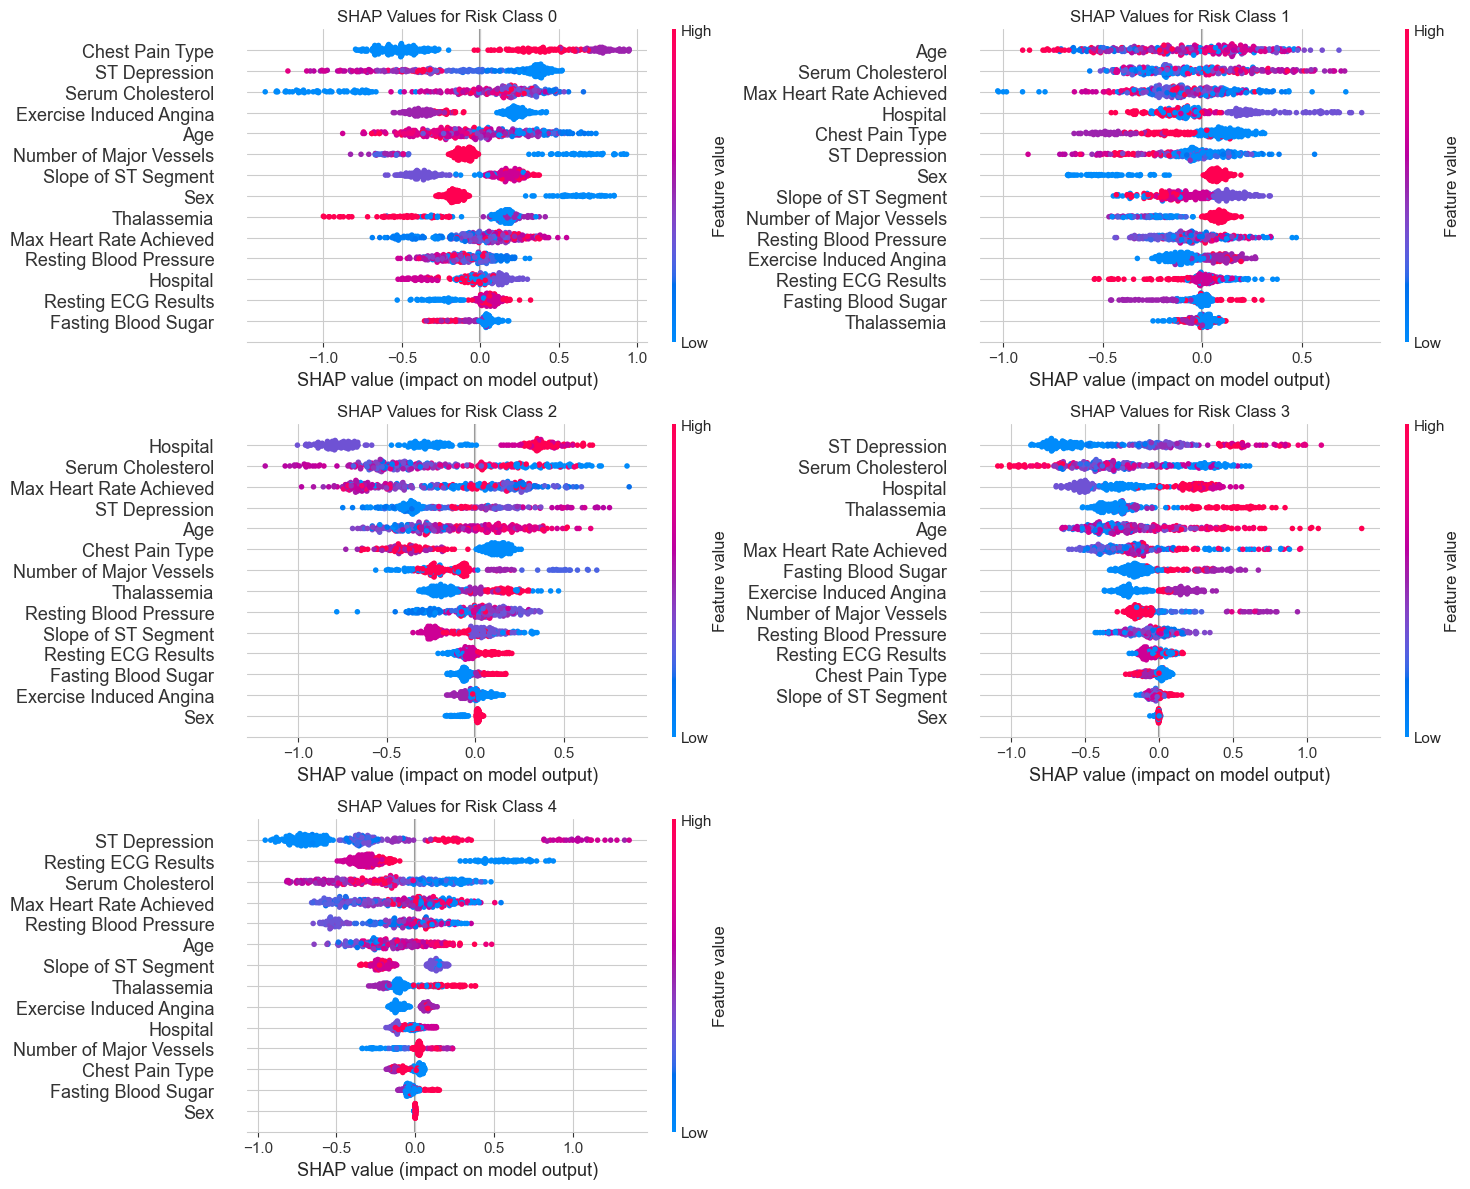

In [115]:
# Fix the SHAP summary plot
feature_names = list(test_df.columns)  # Convert to list to ensure proper indexing
feature_titles = [metadata[col]['title'] if col in metadata and 'title' in metadata[col] else col for col in feature_names]

explainer = shap.TreeExplainer(model)
test_shap_values = explainer(preprocessed_input)
# Save test_shap_values to pickle file
import pickle
with open('data/test_shap_values.pkl', 'wb') as f:
    pickle.dump(test_shap_values, f)


# For multi-class problems, we often want to look at one class at a time
# Let's look at the SHAP values for class 1 (first non-zero risk class)
import matplotlib.pyplot as plt
# Plot SHAP summary plots for all classes
plt.figure(figsize=(15, 12))

for class_idx in range(5):  # Plot for all 5 classes (0-4)
    plt.subplot(3, 2, class_idx + 1)
    shap.summary_plot(test_shap_values[:,:,class_idx], preprocessed_input, 
                     feature_names=feature_titles,
                     show=False,
                     plot_size=None)  # Disable automatic figure creation
    plt.title(f'SHAP Values for Risk Class {class_idx}')

plt.tight_layout()
plt.show()


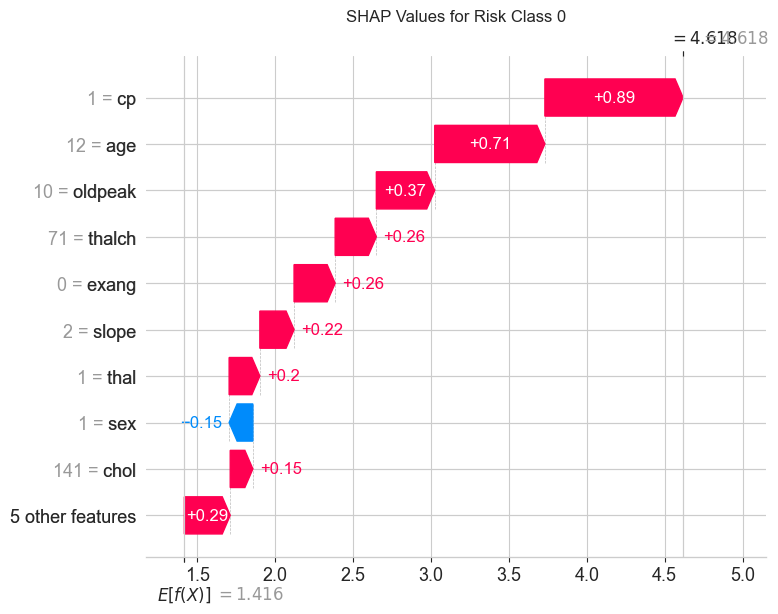

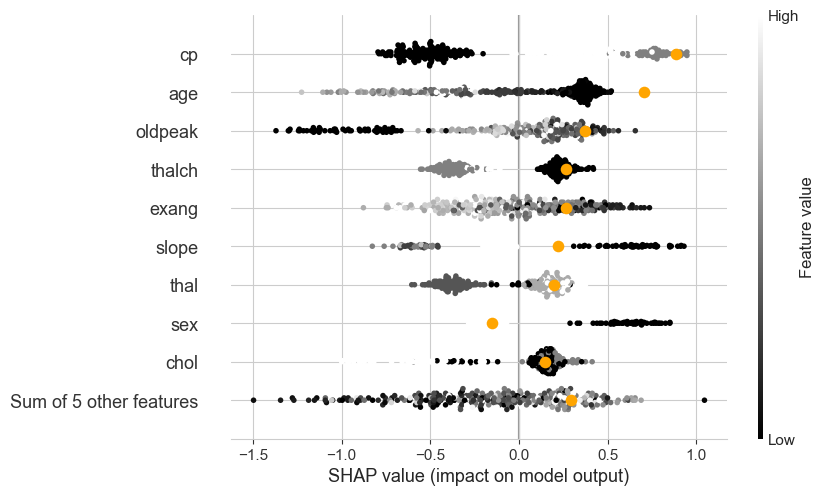

In [116]:
def do_shap():
    input_df = test_df.sample(1)  # Remove int() as we want a DataFrame, not an integer

    # Run the model and get the prediction probabilities
    risk_prediction = pipeline.predict(input_df)
    risk_prediction = risk_prediction[0]  # Get single prediction

    # Preprocess the input
    preprocessing_pipeline = pipeline[:-1]
    single_preprocessed_input = preprocessing_pipeline.transform(input_df)

    # Get the XGBoost model
    xgboost_model = pipeline.named_steps["regressor"]

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(xgboost_model)
    shap_values = explainer(single_preprocessed_input)

    # Map feature names to titles
    feature_names = list(input_df.columns)
    feature_titles = [
        metadata[col]["title"] if col in metadata and "title" in metadata[col] else col
        for col in feature_names
    ]

    # For multi-class, we need to specify which class's SHAP values to plot
    class_idx = risk_prediction  # Plot for the predicted class

    # Create waterfall plot for the specific class
    shap.plots.waterfall(shap_values[0, :, class_idx], show=False)
    plt.title(f'SHAP Values for Risk Class {class_idx}')
    plt.show()

    shap.plots.beeswarm(test_shap_values[:,:,class_idx], show=False, color="grey")
    shap.plots.beeswarm(shap_values[:,:,class_idx], show=False, s=70, color="orange")
    plt.show()
do_shap()

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tabulate import tabulate
import numpy as np

# Calculate overall classification metrics
metrics = {
    'Accuracy': accuracy_score(test_df['label'], predictions),
    'Macro Precision': precision_score(test_df['label'], predictions, average='macro'),
    'Macro Recall': recall_score(test_df['label'], predictions, average='macro'),
    'Macro F1': f1_score(test_df['label'], predictions, average='macro')
}

# Print overall metrics table
print("Overall Classification Metrics:")
metrics_table = [[metric, f"{value:.3f}"] for metric, value in metrics.items()]
print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='grid'))

# Analysis by class
print("\nMetrics by Class:")
class_metrics = []
for class_num in range(5):  # 0-4 classes
    mask = (test_df['label'] == class_num)
    if mask.any():
        class_precision = precision_score(test_df['label'] == class_num, predictions == class_num)
        class_recall = recall_score(test_df['label'] == class_num, predictions == class_num)
        class_f1 = f1_score(test_df['label'] == class_num, predictions == class_num)
        class_count = mask.sum()
        
        class_metrics.append([
            class_num,
            class_count,
            f"{class_precision:.3f}",
            f"{class_recall:.3f}", 
            f"{class_f1:.3f}"
        ])

print(tabulate(class_metrics,
              headers=['Class', 'Count', 'Precision', 'Recall', 'F1 Score'],
              tablefmt='grid'))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_df['label'], predictions)

# Print confusion matrix in ASCII format
print("\nConfusion Matrix:")
print("Predicted →")
print("Actual ↓")
header = "    " + "   ".join(str(i) for i in range(5))
print(header)
for i, row in enumerate(conf_matrix):
    print(f"{i}   " + "   ".join(f"{cell:2d}" for cell in row))

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_df['label'], predictions,
                          target_names=[f"Class {i}" for i in range(5)],
                          digits=3))

# Calculate additional per-class metrics
class_stats = []
for class_num in range(5):
    true_pos = conf_matrix[class_num, class_num]
    false_pos = conf_matrix[:, class_num].sum() - true_pos
    false_neg = conf_matrix[class_num, :].sum() - true_pos
    total = conf_matrix.sum()
    true_neg = total - (true_pos + false_pos + false_neg)
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    specificity = true_neg / (true_neg + false_pos) if (true_neg + false_pos) > 0 else 0
    
    class_stats.append([
        class_num,
        f"{precision:.3f}",
        f"{recall:.3f}",
        f"{specificity:.3f}"
    ])

print("\nDetailed Per-class Metrics:")
print(tabulate(class_stats,
              headers=['Class', 'Precision', 'Recall', 'Specificity'],
              tablefmt='grid'))

# Analyze model performance on non-zero risk ratings
print("\nAnalysis of Non-Zero Risk Detection:")

# Calculate metrics specifically for non-zero classes
nonzero_classes = range(1,5) # Classes 1-4 represent non-zero risk
zero_class = 0

# Get predictions for non-zero classes
nonzero_actual = test_df['label'] > 0
nonzero_pred = predictions > 0

# Calculate metrics
nonzero_precision = precision_score(nonzero_actual, nonzero_pred)
nonzero_recall = recall_score(nonzero_actual, nonzero_pred)
nonzero_f1 = f1_score(nonzero_actual, nonzero_pred)

# Calculate confusion matrix for binary case (zero vs non-zero)
binary_cm = confusion_matrix(nonzero_actual, nonzero_pred)
tn, fp, fn, tp = binary_cm.ravel()

print("\nBinary Classification Metrics (Zero vs Non-Zero Risk):")
print(f"Precision (Non-Zero Risk): {nonzero_precision:.3f}")
print(f"Recall (Non-Zero Risk): {nonzero_recall:.3f}")
print(f"F1 Score (Non-Zero Risk): {nonzero_f1:.3f}")

print("\nConfusion Matrix (Zero vs Non-Zero Risk):")
print("                Predicted No Risk  Predicted Risk")
print(f"Actual No Risk         {tn:12d}  {fp:14d}")
print(f"Actual Risk           {fn:12d}  {tp:14d}")

# Calculate percentage of correct risk detections
total_risk_cases = nonzero_actual.sum()
correct_risk_detections = tp
risk_detection_rate = correct_risk_detections / total_risk_cases

print(f"\nRisk Detection Rate: {risk_detection_rate:.1%} of actual risk cases were correctly identified")

# Calculate false negative rate (missed risks)
false_negative_rate = fn / (fn + tp)
print(f"Missed Risk Rate: {false_negative_rate:.1%} of actual risk cases were incorrectly classified as no risk")

# Calculate false positive rate (false alarms)
false_positive_rate = fp / (fp + tn)
print(f"False Alarm Rate: {false_positive_rate:.1%} of actual no-risk cases were incorrectly classified as risk")


Overall Classification Metrics:
+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| Accuracy        |   0.622 |
+-----------------+---------+
| Macro Precision |   0.419 |
+-----------------+---------+
| Macro Recall    |   0.428 |
+-----------------+---------+
| Macro F1        |   0.423 |
+-----------------+---------+

Metrics by Class:
+---------+---------+-------------+----------+------------+
|   Class |   Count |   Precision |   Recall |   F1 Score |
+=========+=========+=============+==========+============+
|       0 |     136 |       0.786 |    0.838 |      0.811 |
+---------+---------+-------------+----------+------------+
|       1 |      88 |       0.593 |    0.545 |      0.568 |
+---------+---------+-------------+----------+------------+
|       2 |      36 |       0.405 |    0.472 |      0.436 |
+---------+---------+-------------+----------+------------+
|       3 |      35 |       0.312 |    0.286 |      0.299 |
+---------+--------

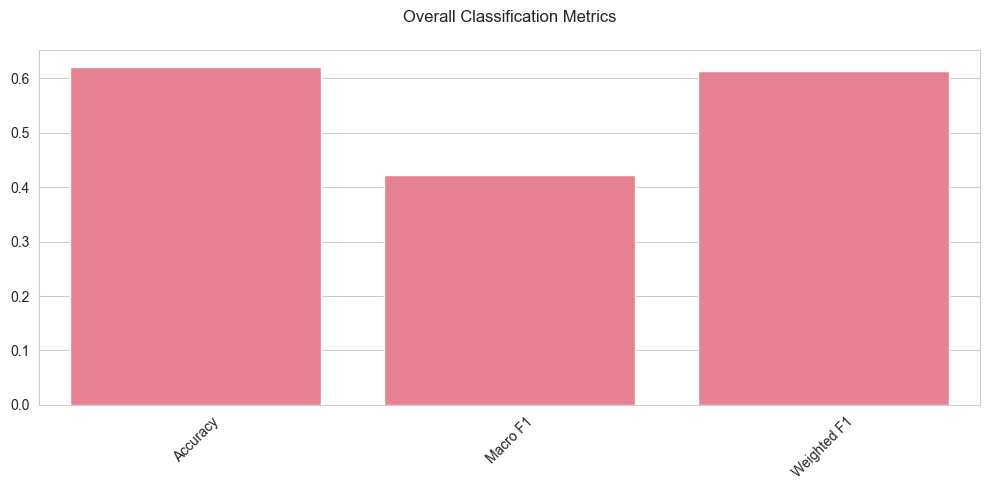

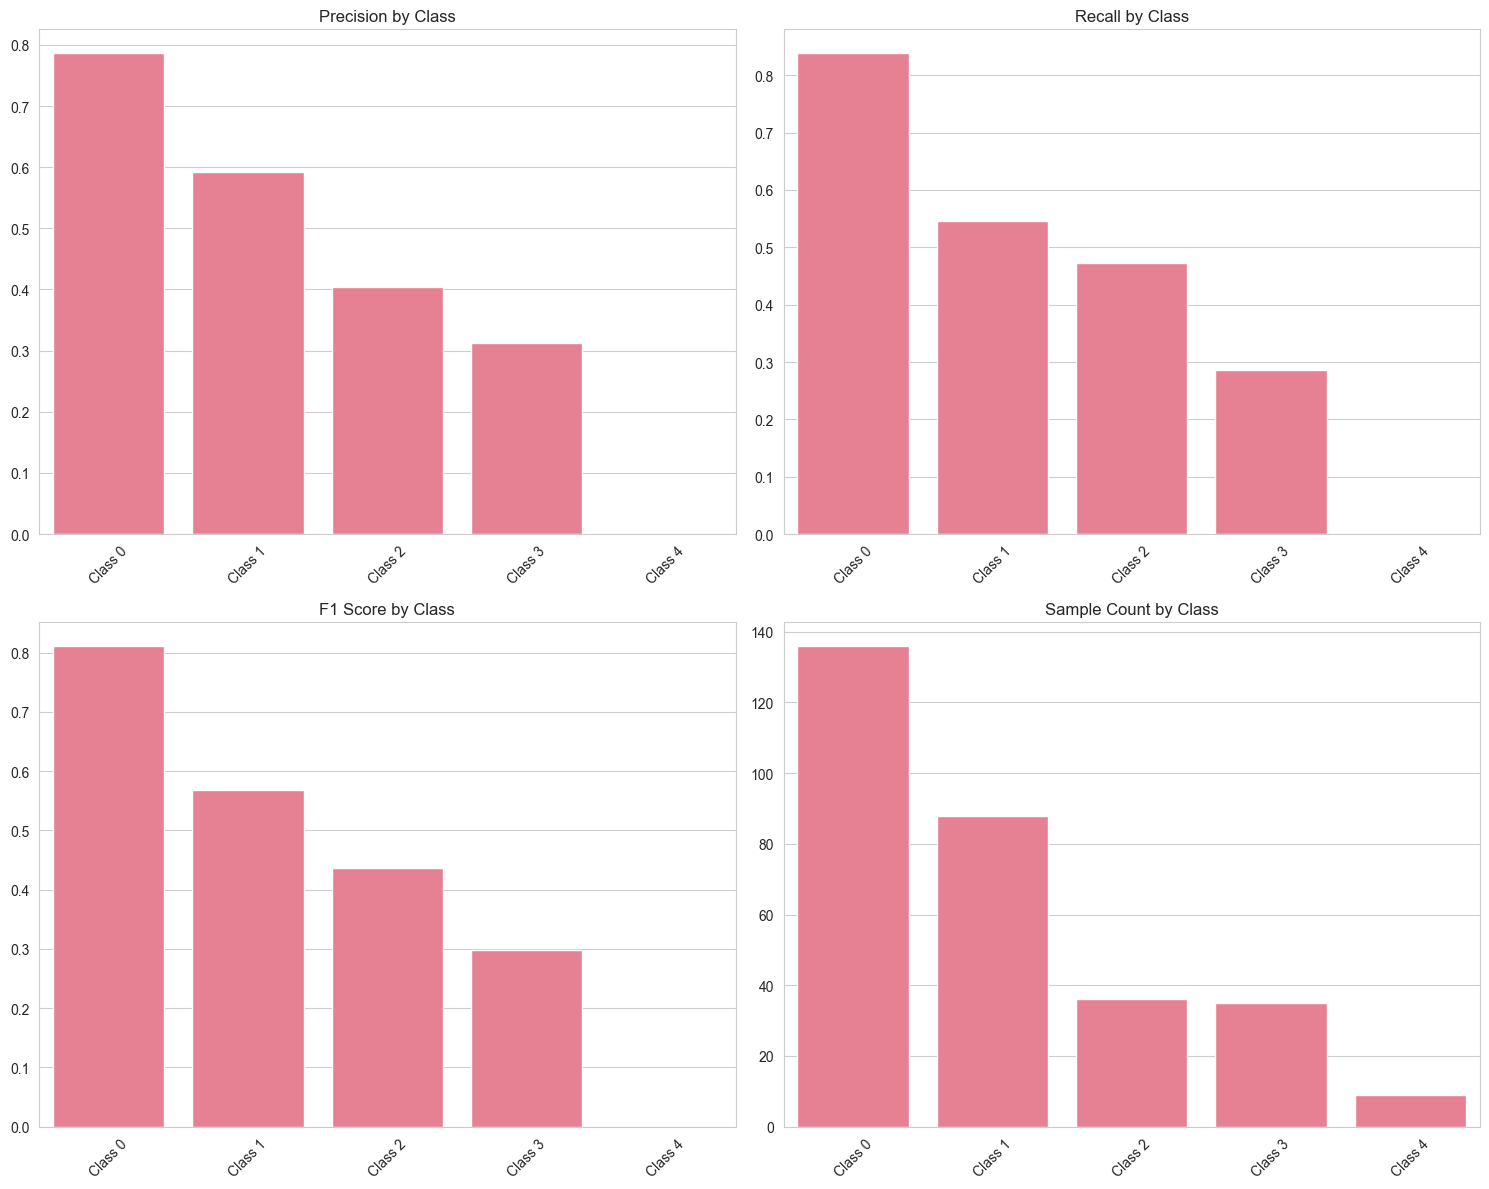

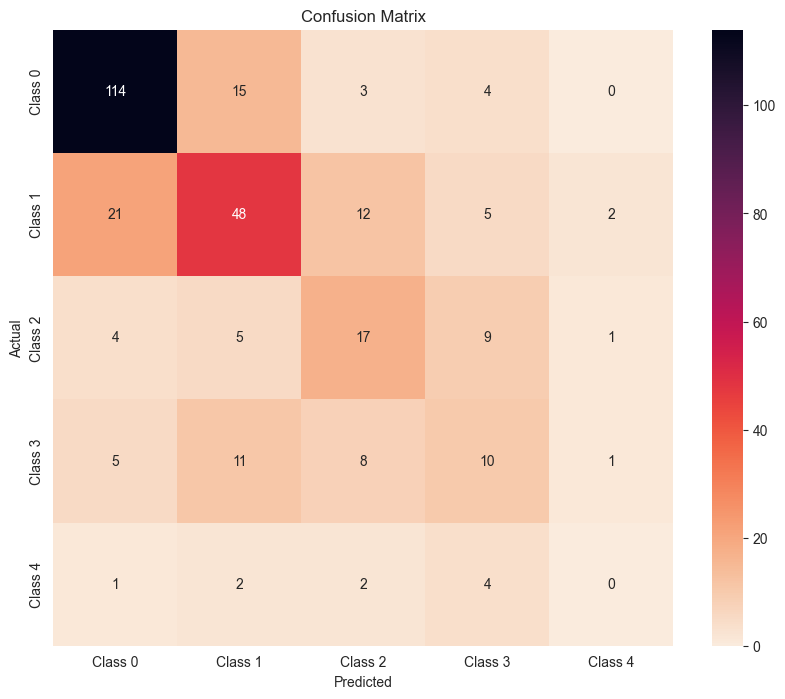

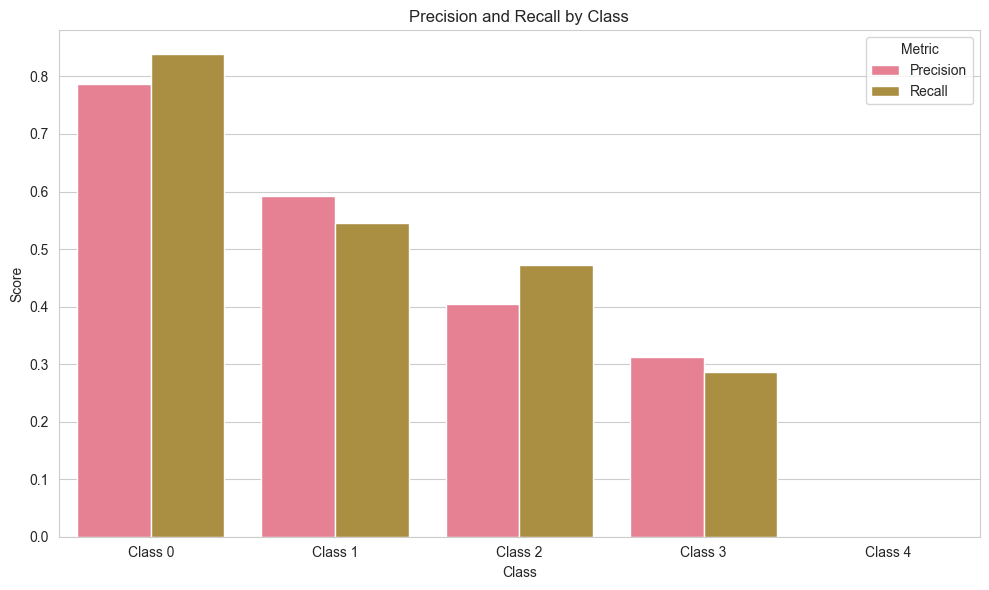

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Calculate overall classification metrics
metrics = {
    'Accuracy': accuracy_score(test_df['label'], predictions),
    'Macro F1': f1_score(test_df['label'], predictions, average='macro'),
    'Weighted F1': f1_score(test_df['label'], predictions, average='weighted')
}

# Create a bar plot for overall metrics
plt.figure(figsize=(10, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Overall Classification Metrics', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis by class
class_metrics_dict = {}
for class_num in range(5):  # 0-4 classes
    mask = (test_df['label'] == class_num)
    if mask.any():
        class_metrics_dict[f'Class {class_num}'] = {
            'Precision': precision_score(test_df['label'], predictions, labels=[class_num], average='micro'),
            'Recall': recall_score(test_df['label'], predictions, labels=[class_num], average='micro'),
            'F1': f1_score(test_df['label'], predictions, labels=[class_num], average='micro'),
            'Support': mask.sum()
        }

# Create subplots for class-wise metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot Precision by class
classes = list(class_metrics_dict.keys())
precision_values = [metrics['Precision'] for metrics in class_metrics_dict.values()]
sns.barplot(x=classes, y=precision_values, ax=ax1)
ax1.set_title('Precision by Class')
ax1.set_xticklabels(classes, rotation=45)

# Plot Recall by class
recall_values = [metrics['Recall'] for metrics in class_metrics_dict.values()]
sns.barplot(x=classes, y=recall_values, ax=ax2)
ax2.set_title('Recall by Class')
ax2.set_xticklabels(classes, rotation=45)

# Plot F1 by class
f1_values = [metrics['F1'] for metrics in class_metrics_dict.values()]
sns.barplot(x=classes, y=f1_values, ax=ax3)
ax3.set_title('F1 Score by Class')
ax3.set_xticklabels(classes, rotation=45)

# Plot support count by class
support_values = [metrics['Support'] for metrics in class_metrics_dict.values()]
sns.barplot(x=classes, y=support_values, ax=ax4)
ax4.set_title('Sample Count by Class')
ax4.set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_df['label'], predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', 
            xticklabels=[f'Class {i}' for i in range(5)],
            yticklabels=[f'Class {i}' for i in range(5)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate precision and recall for visualization
class_stats = []
precisions = []
recalls = []
for class_num in range(5):
    true_pos = conf_matrix[class_num, class_num]
    false_pos = conf_matrix[:, class_num].sum() - true_pos
    false_neg = conf_matrix[class_num, :].sum() - true_pos
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall using seaborn
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame({
    'Class': [f'Class {i}' for i in range(5)] * 2,
    'Score': precisions + recalls,
    'Metric': ['Precision'] * 5 + ['Recall'] * 5
})

sns.barplot(data=metrics_df, x='Class', y='Score', hue='Metric')
plt.title('Precision and Recall by Class')
plt.tight_layout()
plt.show()
